- Reference
  - https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

In [1]:
import os

In [2]:
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/saved_models', exist_ok=True)

In [34]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Embedding
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [14]:
class CGAN():
    def __init__(self):
        # Input shape, NHWC
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        self.d_inner_model = None
        self.discriminator = None
        self.g_inner_model = None
        self.generator = None

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()
        self.g_inner_model = model

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])

        img = self.g_inner_model(model_input)

        model2 = Model([noise, label], img)

        return model2

    def build_discriminator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        #model.summary()
        self.d_inner_model = model

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = self.d_inner_model(model_input)

        model2 = Model([img, label], validity)

        return model2

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1

        fig.savefig('data/images/%d.png' % epoch)

        plt.close()

In [15]:
cgan = CGAN()
cgan.train(epochs=10, batch_size=32, sample_interval=3)

0 [D loss: 0.698140, acc.: 15.62%] [G loss: 0.689029]
1 [D loss: 0.688860, acc.: 43.75%] [G loss: 0.681260]
2 [D loss: 0.681944, acc.: 50.00%] [G loss: 0.674358]
3 [D loss: 0.670902, acc.: 50.00%] [G loss: 0.665569]
4 [D loss: 0.664591, acc.: 50.00%] [G loss: 0.656669]
5 [D loss: 0.657215, acc.: 50.00%] [G loss: 0.648440]
6 [D loss: 0.641842, acc.: 50.00%] [G loss: 0.637901]
7 [D loss: 0.625480, acc.: 50.00%] [G loss: 0.629168]
8 [D loss: 0.607614, acc.: 50.00%] [G loss: 0.611396]
9 [D loss: 0.581193, acc.: 50.00%] [G loss: 0.605409]


In [16]:
from tensorflow.keras.utils import plot_model

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 100)       1000        input_16[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 100)          0           embedding_5[0][0]                
____________________________________________________________________________________________

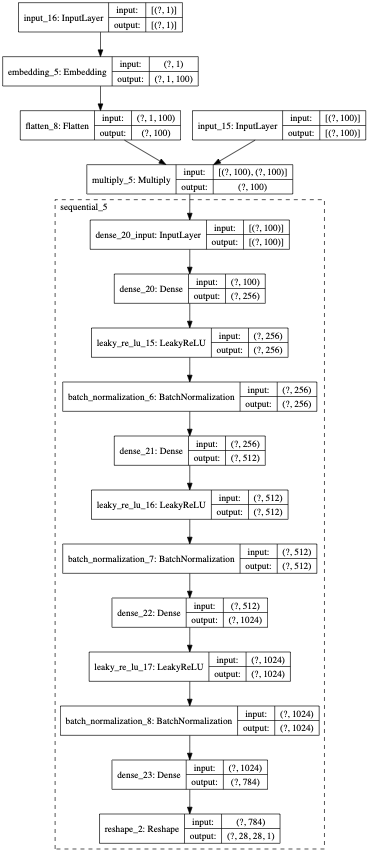

In [31]:
cgan.generator.summary()
#plot_model(cgan.generator, show_shapes=True, dpi=48)
plot_model(cgan.generator, show_shapes=True, dpi=48, expand_nested=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_22 (Dense)             (None, 1024)             

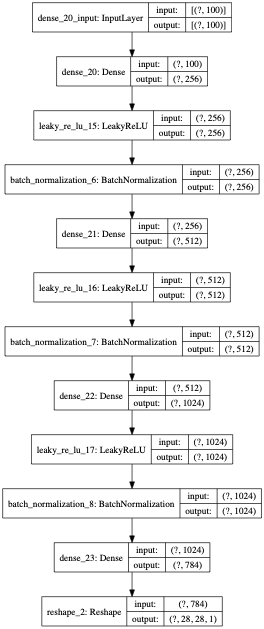

In [25]:
cgan.g_inner_model.summary()
plot_model(cgan.g_inner_model, show_shapes=True, dpi=48)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 784)       7840        input_14[0][0]                   
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 784)          0           input_13[0][0]                   
____________________________________________________________________________________________

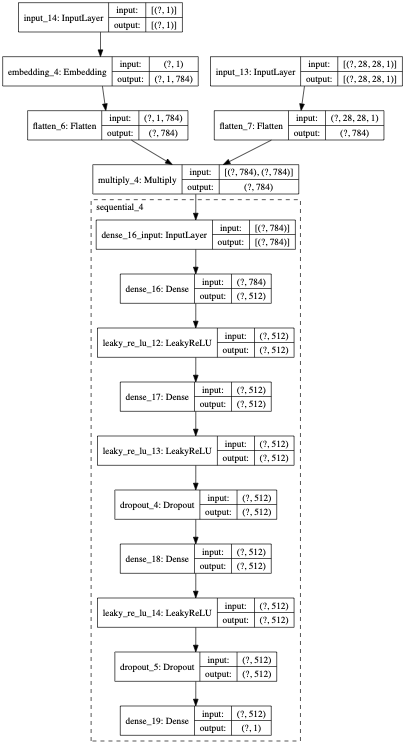

In [36]:
cgan.discriminator.summary()
#plot_model(cgan.discriminator, show_shapes=True, dpi=48, expand_nested=True)
#plot_model(cgan.discriminator, show_shapes=True, show_layer_names=False)

# Reference: https://qiita.com/HyperPigeon/items/fb22b555e76b52b3d688
from tensorflow.keras.layers import Layer

cgan.discriminator._layers = [
  layer for layer in cgan.discriminator._layers if isinstance(layer, Layer)
]
plot_model(cgan.discriminator, show_shapes=True, dpi=48, expand_nested=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)              

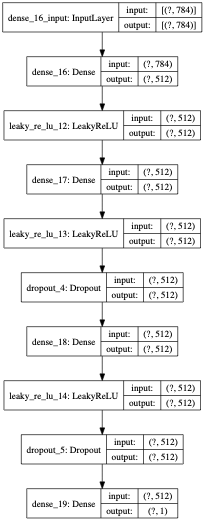

In [30]:
cgan.d_inner_model.summary()
plot_model(cgan.d_inner_model, show_shapes=True, dpi=48)